In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import scipy

import rpy2
from rpy2.robjects import r
NULL = r("NULL")
import sys
sys.path.append('../') # Add one directory back to the path

from PFAS_DR import PFAS_DR
%load_ext rpy2.ipython
%load_ext watermark
%watermark -iv

R[write to console]: The mod.exe had been created.



matplotlib: 3.5.3
pandas    : 1.5.2
seaborn   : 0.11.2
numpy     : 1.21.2
scipy     : 1.10.0
sys       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
rpy2      : 3.4.4
sklearn   : 0.24.2



Use this notebook to generate summary figures to compare model predictions with measured PK data in the literature

In [2]:
model_path = '../pfoa_2compabandersenoral_1cmptDev'
param_path = '../data_files'

def convert_time(row):
    if row.time_units == 'hours':
        return row.time/24.
    elif row.time_units == 'days':
        return row.time
def map_dose_range(row):
    if row.dose <= 5.:
        return 'dose <= 5 mg/kg'
    elif row.dose > 5 and row.dose <= 20.:
        return '5 mg/kg < dose <= 20 mg/kg'
    elif row.dose > 20 and row.dose <= 60.:
        return '20 mg/kg < dose <= 60 mg/kg'
    elif row.dose > 60:
        return 'dose > 60 mg/kg'
    
def run_sim(grp):
    global output, times, tmp
    strain = grp.strain.unique()[0]
    sex = grp.sex.unique()[0]
    chem = grp.chemical.unique()[0]
    times = grp.time_sim.values
    if 'BW' in grp.columns:
        M_m_1 = grp.BW.unique()[0]
    else:
        M_m_1 = None
    if strain == 'rat' and sex == 'Male':
        if M_m_1 is None:
            M_m_1 = 0.24
        Qcc = 12.39
    elif strain == 'rat' and sex == 'Female':
        if M_m_1 is None:
            M_m_1 = 0.2
        Qcc = 12.39
    elif strain == 'CD1':
        if M_m_1 is None:
            M_m_1 = 0.02
        Qcc = 8.68
        
    if strain == 'rat' and sex == 'Female' and chem == 'PFOS':
        # Switch Female rat PFOS parameters due to better fit
        sex = 'Male'
        
    #if strain == 'rat' and sex == 'Female' and chem == 'PFOA':
    #    # Switch Female rat PFOS parameters due to better fit
    #    sex = 'Male'
        
        
    dosing_dict = {
        'chem': chem,
        'times': times,
        'sex': sex,
        'route': grp.route.unique()[0],
        'strain': strain,
        'M_m_1': M_m_1,
        'Qcc': Qcc,
        'dose': grp.dose.unique()[0],
        'tm_daily_dose': None,
        'sample_posterior': False,
        'param_path': param_path,
        'model_path': model_path,
        'dev': False,
        'plotting': False,
    }
    #print(dosing_dict)
    tmp_PFAS = PFAS_DR(**dosing_dict)
    tmp_PFAS.run_model()
    tmp = tmp_PFAS.output[['time', 'C_m']]
    #display(tmp)
    output = tmp_PFAS.output.C_m.values
    grp['conc_pred'] = output
    return grp

# Import the data

Data in `lit_data.csv` have a train flag where 1 means the data were used to train the Wanbaugh model and 0 means the data weren't not used.

In [3]:
all_data = pd.read_csv('./lit_data.csv')
all_data['time_sim'] = np.round(all_data.apply(convert_time, axis=1), 5)
all_data['dose_range'] = all_data.apply(map_dose_range, axis=1)
all_data.head()

,hero_id,author,chemical,strain,sex,route,dose,dose_units,time,time_units,conc_mean,conc_units,train,time_sim,dose_range
0,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,5.600807,hours,5.331983,mg/L,1,0.23337,dose <= 5 mg/kg
1,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,12.685409,hours,8.707768,mg/L,1,0.52856,dose <= 5 mg/kg
2,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,22.612212,hours,7.990960,mg/L,1,0.94218,dose <= 5 mg/kg
3,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,72.538806,hours,7.331359,mg/L,1,3.02245,dose <= 5 mg/kg
4,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,149.111029,hours,6.562167,mg/L,1,6.21296,dose <= 5 mg/kg


# Training data

Predict the training data set to make sure the current model predicts the training data

In [4]:
train = all_data[(all_data.train == 1) & (all_data.time_sim > 0)].copy()
train.loc[:, 'conc_pred'] = np.nan # intitialize prediction column
train.head()

,hero_id,author,chemical,strain,sex,route,dose,dose_units,time,time_units,conc_mean,conc_units,train,time_sim,dose_range,conc_pred
0,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,5.600807,hours,5.331983,mg/L,1,0.23337,dose <= 5 mg/kg,NaN
1,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,12.685409,hours,8.707768,mg/L,1,0.52856,dose <= 5 mg/kg,NaN
2,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,22.612212,hours,7.990960,mg/L,1,0.94218,dose <= 5 mg/kg,NaN
3,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,72.538806,hours,7.331359,mg/L,1,3.02245,dose <= 5 mg/kg,NaN
4,2919359.0,Lou,PFOA,CD1,Female,oral,1.0,mg/kg,149.111029,hours,6.562167,mg/L,1,6.21296,dose <= 5 mg/kg,NaN


In [5]:
train = train.groupby(['author', 'chemical', 'strain', 'sex', 'route', 'dose']).apply(run_sim) # Run the simulation for each training dataset

Running adult model for CD1 with 1.0 mg/kg PFOS
Running adult model for CD1 with 20.0 mg/kg PFOS
Running adult model for CD1 with 1.0 mg/kg PFOS
Running adult model for CD1 with 20.0 mg/kg PFOS
Running adult model for rat with 2.0 mg/kg PFOS
Running adult model for rat with 2.0 mg/kg PFOS
Running adult model for rat with 15.0 mg/kg PFOS
Running adult model for rat with 1.0 mg/kg PFOA
Running adult model for rat with 0.1 mg/kg PFOA
Running adult model for rat with 1.0 mg/kg PFOA
Running adult model for rat with 5.0 mg/kg PFOA
Running adult model for rat with 15.0 mg/kg PFOA
Running adult model for rat with 1.0 mg/kg PFOA
Running adult model for rat with 0.1 mg/kg PFOA
Running adult model for rat with 1.0 mg/kg PFOA
Running adult model for rat with 5.0 mg/kg PFOA
Running adult model for rat with 25.0 mg/kg PFOA
Running adult model for CD1 with 1.0 mg/kg PFOA
Running adult model for CD1 with 10.0 mg/kg PFOA
Running adult model for CD1 with 60.0 mg/kg PFOA


## PFOA: Training data

Text(0.5, 0, 'Literature reported concentration (mg/L)')

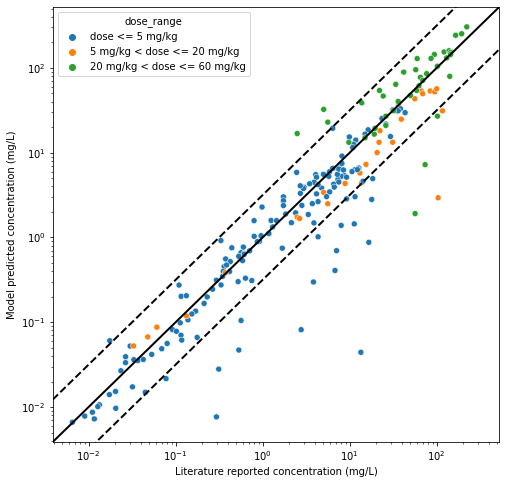

In [7]:
chem = 'PFOA'
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.scatterplot(x='conc_mean', y='conc_pred', data=train[train.chemical==chem], hue='dose_range', ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ylim = ax.get_ylim()
xlim = ax.get_xlim()
axis_max = max(xlim[1], ylim[1])
axis_min = min(xlim[0], ylim[0])
ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k-', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**0.5), axis_max*(10**0.5)], 'k--', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**-0.5), axis_max*(10**-0.5)], 'k--', linewidth=2)
ax.set_ylim([axis_min, axis_max])
ax.set_xlim([axis_min, axis_max])
ax.set_ylabel('Model predicted concentration (mg/L)')
ax.set_xlabel('Literature reported concentration (mg/L)')

In [8]:
print('MSLE: ', np.round(skm.mean_squared_log_error(train.loc[train.chemical==chem, 'conc_mean'], train.loc[train.chemical==chem, 'conc_pred']), 3))
print('R^2: ', np.round(skm.r2_score(train.loc[train.chemical==chem, 'conc_mean'], train.loc[train.chemical==chem, 'conc_pred']), 3))

MSLE:  0.395
R^2:  0.755


## PFOS: Training data

Text(0.5, 0, 'Literature reported concentration (mg/L)')

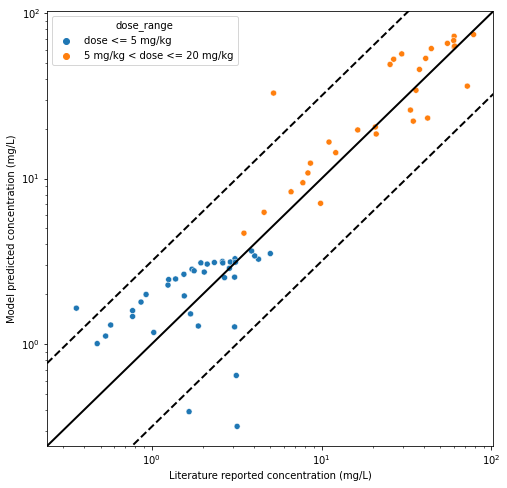

In [9]:
chem = 'PFOS'
fig, ax = plt.subplots(1,1, figsize=(8,8))
#sns.scatterplot(x='conc_mean', y='conc_pred', data=train[train.chemical==chem], hue='time', ax=ax, palette='cool')
sns.scatterplot(x='conc_mean', y='conc_pred', data=train[train.chemical==chem], hue='dose_range', ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ylim = ax.get_ylim()
xlim = ax.get_xlim()
axis_max = max(xlim[1], ylim[1])
axis_min = min(xlim[0], ylim[0])
ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k-', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**0.5), axis_max*(10**0.5)], 'k--', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**-0.5), axis_max*(10**-0.5)], 'k--', linewidth=2)
ax.set_ylim([axis_min, axis_max])
ax.set_xlim([axis_min, axis_max])
ax.set_ylabel('Model predicted concentration (mg/L)')
ax.set_xlabel('Literature reported concentration (mg/L)')

In [10]:
print('MSLE: ', np.round(skm.mean_squared_log_error(train.loc[train.chemical==chem, 'conc_mean'], train.loc[train.chemical==chem, 'conc_pred']), 3))
print('R^2: ', np.round(skm.r2_score(train.loc[train.chemical==chem, 'conc_mean'], train.loc[train.chemical==chem, 'conc_pred']), 3))

MSLE:  0.174
R^2:  0.805


# Test data

In [11]:
test = all_data[(all_data.train == 0) & (all_data.time_sim > 0)].copy()
test.loc[:, 'conc_pred'] = np.nan # intitialize prediction column
test.head()

,hero_id,author,chemical,strain,sex,route,dose,dose_units,time,time_units,conc_mean,conc_units,train,time_sim,dose_range,conc_pred
304,5916078.0,Dzierlenga,PFOA,rat,Male,IV,6.0,mg/kg,0.003,days,61.531,mg/L,0,0.003,5 mg/kg < dose <= 20 mg/kg,NaN
305,5916078.0,Dzierlenga,PFOA,rat,Male,IV,6.0,mg/kg,0.010,days,53.491,mg/L,0,0.010,5 mg/kg < dose <= 20 mg/kg,NaN
306,5916078.0,Dzierlenga,PFOA,rat,Male,IV,6.0,mg/kg,0.020,days,46.526,mg/L,0,0.020,5 mg/kg < dose <= 20 mg/kg,NaN
307,5916078.0,Dzierlenga,PFOA,rat,Male,IV,6.0,mg/kg,0.041,days,46.489,mg/L,0,0.041,5 mg/kg < dose <= 20 mg/kg,NaN
308,5916078.0,Dzierlenga,PFOA,rat,Male,IV,6.0,mg/kg,0.123,days,47.620,mg/L,0,0.123,5 mg/kg < dose <= 20 mg/kg,NaN


In [12]:
test = test.groupby(['author', 'chemical', 'strain', 'sex', 'route', 'dose']).apply(run_sim)

Running adult model for rat with 40.0 mg/kg PFOA
Running adult model for rat with 40.0 mg/kg PFOA
Running adult model for rat with 80.0 mg/kg PFOA
Running adult model for rat with 320.0 mg/kg PFOA
Running adult model for rat with 6.0 mg/kg PFOA
Running adult model for rat with 6.0 mg/kg PFOA
Running adult model for rat with 12.0 mg/kg PFOA
Running adult model for rat with 45.0 mg/kg PFOA
Running adult model for rat with 2.0 mg/kg PFOS
Running adult model for rat with 2.0 mg/kg PFOS
Running adult model for rat with 20.0 mg/kg PFOS
Running adult model for rat with 2.0 mg/kg PFOS
Running adult model for rat with 2.0 mg/kg PFOS
Running adult model for rat with 20.0 mg/kg PFOS
Running adult model for rat with 1.0 mg/kg PFOA
Running adult model for rat with 1.0 mg/kg PFOA
Running adult model for rat with 1.0 mg/kg PFOA
Running adult model for rat with 1.0 mg/kg PFOA
Running adult model for rat with 2.0 mg/kg PFOS
Running adult model for rat with 2.0 mg/kg PFOS
Running adult model for rat wit

## PFOA: Test data

Text(0.5, 0, 'Literature reported concentration (mg/L)')

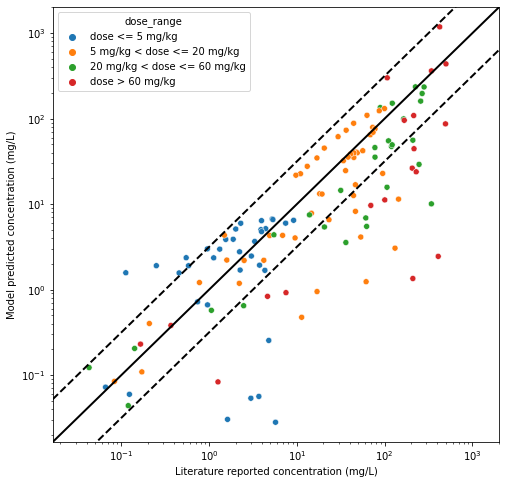

In [13]:
chem = 'PFOA'
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.scatterplot(x='conc_mean', y='conc_pred', data=test[test.chemical==chem], hue='dose_range', ax=ax, hue_order=['dose <= 5 mg/kg', '5 mg/kg < dose <= 20 mg/kg', '20 mg/kg < dose <= 60 mg/kg', 'dose > 60 mg/kg'])
ax.set_xscale('log')
ax.set_yscale('log')
ylim = ax.get_ylim()
xlim = ax.get_xlim()
axis_max = max(xlim[1], ylim[1])
axis_min = min(xlim[0], ylim[0])
ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k-', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**0.5), axis_max*(10**0.5)], 'k--', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**-0.5), axis_max*(10**-0.5)], 'k--', linewidth=2)
ax.set_ylim([axis_min, axis_max])
ax.set_xlim([axis_min, axis_max])
ax.set_ylabel('Model predicted concentration (mg/L)')
ax.set_xlabel('Literature reported concentration (mg/L)')

In [14]:
print('MSLE: ', np.round(skm.mean_squared_log_error(test.loc[test.chemical==chem, 'conc_mean'], test.loc[test.chemical==chem, 'conc_pred']), 3))
print('R^2: ', np.round(skm.r2_score(test.loc[test.chemical==chem, 'conc_mean'], test.loc[test.chemical==chem, 'conc_pred']), 3))

MSLE:  1.444
R^2:  -0.01


## PFOS: Test data

(0.002043373838843409, 222.58085589207803)

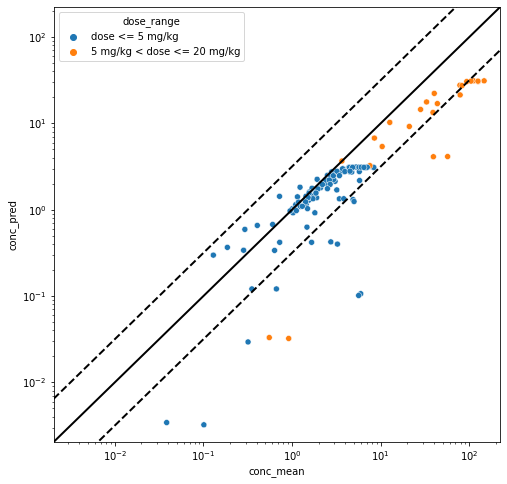

In [15]:
chem = 'PFOS'
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.scatterplot(x='conc_mean', y='conc_pred', data=test[test.chemical==chem], hue='dose_range', ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ylim = ax.get_ylim()
xlim = ax.get_xlim()
axis_max = max(xlim[1], ylim[1])
axis_min = min(xlim[0], ylim[0])
ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k-', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**0.5), axis_max*(10**0.5)], 'k--', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**-0.5), axis_max*(10**-0.5)], 'k--', linewidth=2)
ax.set_ylim([axis_min, axis_max])
ax.set_xlim([axis_min, axis_max])

In [16]:
print('MSLE: ', np.round(skm.mean_squared_log_error(test.loc[test.chemical==chem, 'conc_mean'], test.loc[test.chemical==chem, 'conc_pred']), 3))
print('R^2: ', np.round(skm.r2_score(test.loc[test.chemical==chem, 'conc_mean'], test.loc[test.chemical==chem, 'conc_pred']), 3))

MSLE:  0.384
R^2:  0.363


# Developmental

Each developmental study is in a different format with disparate dosing paramaters. Each subsection predicts the study-specific concentrations and then a comparison is done at the end.

## Hinderliter data

Dose to post-weaning, juvenile, rats at different ages. Use the Wambaugh model with BW-scaling. This isn't a true developmental study, but a post-weaning study where very young rats are exposed at different ages. Age-specific differences in clearance are found as the initial age of the juvenile increases.

In [17]:
hind_data = pd.read_csv('./hinderliter_data.csv')
hind_data['time_sim'] = np.round(hind_data.apply(convert_time, axis=1), 5)
hind_data['dose_range'] = hind_data.apply(map_dose_range, axis=1)
hind_data.loc[:, 'conc_pred'] = np.nan # intitialize prediction column
hind_data.head()

,hero_id,author,age,chemical,strain,sex,BW,route,dose,dose_units,time,time_units,conc_mean,conc_units,time_sim,dose_range,conc_pred
0,3749132,Hinderliter,3wk,PFOA,rat,Male,0.0565,oral,10,mg/kg,2,hours,41.87,mg/L,0.08333,5 mg/kg < dose <= 20 mg/kg,NaN
1,3749132,Hinderliter,3wk,PFOA,rat,Male,0.0565,oral,10,mg/kg,24,hours,34.22,mg/L,1.00000,5 mg/kg < dose <= 20 mg/kg,NaN
2,3749132,Hinderliter,4wk,PFOA,rat,Male,0.0933,oral,10,mg/kg,2,hours,39.92,mg/L,0.08333,5 mg/kg < dose <= 20 mg/kg,NaN
3,3749132,Hinderliter,4wk,PFOA,rat,Male,0.0933,oral,10,mg/kg,24,hours,42.94,mg/L,1.00000,5 mg/kg < dose <= 20 mg/kg,NaN
4,3749132,Hinderliter,5wk,PFOA,rat,Male,0.1100,oral,10,mg/kg,2,hours,26.32,mg/L,0.08333,5 mg/kg < dose <= 20 mg/kg,NaN


In [18]:
hind_data = hind_data.groupby(['author', 'age', 'chemical', 'strain', 'sex', 'route', 'dose']).apply(run_sim)

Running adult model for rat with 10 mg/kg PFOA
Running adult model for rat with 30 mg/kg PFOA
Running adult model for rat with 10 mg/kg PFOA
Running adult model for rat with 30 mg/kg PFOA
Running adult model for rat with 10 mg/kg PFOA
Running adult model for rat with 30 mg/kg PFOA
Running adult model for rat with 10 mg/kg PFOA
Running adult model for rat with 30 mg/kg PFOA
Running adult model for rat with 10 mg/kg PFOA
Running adult model for rat with 30 mg/kg PFOA
Running adult model for rat with 10 mg/kg PFOA
Running adult model for rat with 30 mg/kg PFOA


Text(0.5, 0, 'Literature reported concentration (mg/L)')

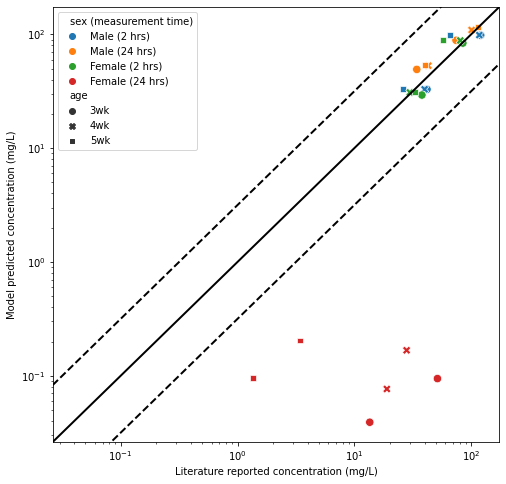

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
#hind_data['study design'] = hind_data['sex'] + ' (' + hind_data['age'] + ')' + ': ' + hind_data['time'].astype(str)
hind_data['sex (measurement time)'] = hind_data['sex'] + ' (' + hind_data['time'].astype(str) + ' hrs)'
sns.scatterplot(x='conc_mean', y='conc_pred', data=hind_data, hue='sex (measurement time)', ax=ax, style='age', s=70)
ax.set_xscale('log')
ax.set_yscale('log')
ylim = ax.get_ylim()
xlim = ax.get_xlim()
axis_max = max(xlim[1], ylim[1])
axis_min = min(xlim[0], ylim[0])
ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k-', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**0.5), axis_max*(10**0.5)], 'k--', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**-0.5), axis_max*(10**-0.5)], 'k--', linewidth=2)
ax.set_ylim([axis_min, axis_max])
ax.set_xlim([axis_min, axis_max])
ax.set_ylabel('Model predicted concentration (mg/L)')
ax.set_xlabel('Literature reported concentration (mg/L)')
fig.savefig('./Hinderliter_2006.jpg', dpi=1200)

## NTP 2-year study

Use the hybrid model to predict concentrations at different lifestages

In [20]:
NTP_compare = pd.DataFrame(columns=['source', 'dam', 'sex', 'lifestage', 'species', 'conc_mean', 'conc_pred'])

### Male pups (Study 1)

Running developmental model
current adult dose 10.9
current infant dose 15.6
Running developmental model
current adult dose 21.7
current infant dose 32.1
Running developmental model
current adult dose 0
current infant dose 15.8
Running developmental model
current adult dose 0
current infant dose 32.1


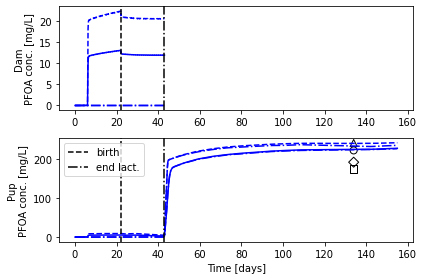

In [21]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation

t_f = 7*19+t_gest # PNW19
#t_f = 2*365 # 2 years
pup_150_150 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_150-150')
dosing_dict = {
    'growth_data': pup_150_150, # Reported pup weights from NTP study
    
    'chem': 'PFOA',
    'ts': 0,         # Start simulation at conception
    'tf': t_f,     # PNW19
    't_dose': 0.999,     # Dose in feed, assume mg/kg/day applied over entire day
    't_dose_i': 0.999,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Male',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 10.9,          # 150 ppm --> mg/kg dose to dam
    't_m_start':6,         # Start maternal dosing on GD6
    't_m_end': 22+21,      # End maternal dosing on 21 days post-partum
    'M_m_1': 0.214,         # Initial Dam weight
    'M_m_2': 0.257,         # Final Dam weight (post-partum)

    'dose_i': 15.6,       # 150 ppm --> mg/kg dose to pup
    't_i_start': 22+21,
    't_i_end': t_f,
    
    # Male infant weights during lactation (Table 9)
    'M_i_1': 0.0071,     # Infant mass 1 (kg).
    'M_i_2': 0.01013,      # Infant mass 2 (kg).
    'M_i_3': 0.01542,      # Infant mass 3 (kg).
    'M_i_4': 0.05061,       # Infant mass 4 (kg).
    
    't_i_1': 1,          # Time (d) since birth for infant mass 1.
    't_i_2': 4,         # Time (d) since birth for infant mass 2.
    't_i_3': 7,         # Time (d) since birth for infant mass 3.
    't_i_4': 21,         # Time (d) since birth for infant mass 4.
    
    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='-')
test_PFOA.plot_data([16*7+t_gest], [175.39], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='s')

NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 175.39, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)

pup_300_300 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_300-300')
test_PFOA.update_p(dose=21.7, dose_i=32.1, growth_data=pup_300_300)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='--')
test_PFOA.plot_data([16*7+t_gest], [223.4], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='o')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 223.4, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)

pup_0_150 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_0-150')
test_PFOA.update_p(dose=0, dose_i=15.8, growth_data=pup_0_150)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='-.')
test_PFOA.plot_data([16*7+t_gest], [193], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='D')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam not dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 193, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)

pup_0_300 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_0-300')
test_PFOA.update_p(dose=0, dose_i=32.1, growth_data=pup_0_300)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='-.')
test_PFOA.plot_data([16*7+t_gest], [242.5], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='^')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam not dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 242.5, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)


test_PFOA.add_features(disp_birth=True, disp_lact=True)
test_PFOA.ax[1].get_legend().remove()
#test_PFOA.ax[0].set_yscale('log')
#test_PFOA.ax[1].set_yscale('log')

### Male pups (Study 2)

Running developmental model
current adult dose 21.7
current infant dose 1.1
Running developmental model
current adult dose 21.7
current infant dose 2.2
Running developmental model
current adult dose 21.7
current infant dose 4.6
Running developmental model
current adult dose 0
current infant dose 1.9
Running developmental model
current adult dose 0
current infant dose 4
Running developmental model
current adult dose 0
current infant dose 8


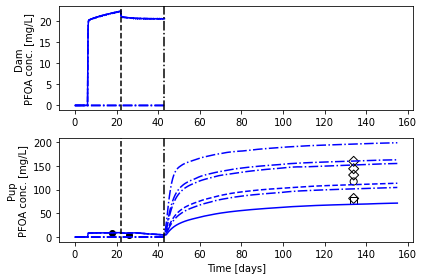

In [22]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation

t_f = 7*19+t_gest # PNW19
#t_f = 2*365 # 2 years
pup_300_20 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_300-20')
dosing_dict = {
    'growth_data': pup_300_20, # Reported pup weights from NTP study
    
    'chem': 'PFOA',
    'ts': 0,         # Start simulation at conception
    'tf': t_f,     # PNW19
    't_dose': 0.999,     # Dose in feed, assume mg/kg/day applied over entire day
    't_dose_i': 0.999,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Male',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 21.7,          # 150 ppm --> mg/kg dose to dam
    't_m_start':6,         # Start maternal dosing on GD6
    't_m_end': 22+21,      # End maternal dosing on 21 days post-partum
    'M_m_1': 0.214,         # Initial Dam weight
    'M_m_2': 0.257,         # Final Dam weight (post-partum)

    'dose_i': 1.1,       # 20 ppm --> mg/kg dose to pup
    't_i_start': 22+21,
    't_i_end': t_f,
    
    # Male infant weights during lactation (Table 9)
    'M_i_1': 0.0071,     # Infant mass 1 (kg).
    'M_i_2': 0.01013,      # Infant mass 2 (kg).
    'M_i_3': 0.01542,      # Infant mass 3 (kg).
    'M_i_4': 0.05061,       # Infant mass 4 (kg).
    
    't_i_1': 1,          # Time (d) since birth for infant mass 1.
    't_i_2': 4,         # Time (d) since birth for infant mass 2.
    't_i_3': 7,         # Time (d) since birth for infant mass 3.
    't_i_4': 21,         # Time (d) since birth for infant mass 4.
    
    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='-')
test_PFOA.plot_data([16*7+t_gest], [78.03], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='s')
test_PFOA.plot_data([18, 4+t_gest], [9.3, 4.5], lifestage='pup', color='black')

NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 78.03, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'lactation', 'conc_mean': 4.5, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 4+t_gest, 'C_i'].item()}, ignore_index=True)
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'pre-natal', 'conc_mean': 9.3, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 18, 'C_i'].item()}, ignore_index=True)

pup_300_40 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_300-40')
test_PFOA.update_p(dose=21.7, dose_i=2.2, growth_data=pup_300_40)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='--')
test_PFOA.plot_data([16*7+t_gest], [117.06], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='o')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 117.06, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)

pup_300_80 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_300-80')
test_PFOA.update_p(dose=21.7, dose_i=4.6, growth_data=pup_300_80)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='-.')
test_PFOA.plot_data([16*7+t_gest], [144.1], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='D')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 144.1, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)


pup_0_20 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_0-20')
test_PFOA.update_p(dose=0, dose_i=1.9, growth_data=pup_0_20)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='-.')
test_PFOA.plot_data([16*7+t_gest], [81.4], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='D')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam not dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 81.4, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)

pup_0_40 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_0-40')
test_PFOA.update_p(dose=0, dose_i=4, growth_data=pup_0_40)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='-.')
test_PFOA.plot_data([16*7+t_gest], [130.78], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='D')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam not dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 130.78, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)

pup_0_80 = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Male_0-80')
test_PFOA.update_p(dose=0, dose_i=8, growth_data=pup_0_80)
test_PFOA.run_model()
test_PFOA.plot_time_course(color='blue', linestyle='-.')
test_PFOA.plot_data([16*7+t_gest], [159.6], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='D')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam not dosed', 'sex': 'Male', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 159.6, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)



test_PFOA.add_features(disp_birth=True, disp_lact=True)
test_PFOA.ax[1].get_legend().remove()
#test_PFOA.ax[0].set_yscale('log')
#test_PFOA.ax[1].set_yscale('log')

### Female pups

Running developmental model
current adult dose 0
current infant dose 21.8
Running developmental model
current adult dose 0
current infant dose 104.4
Running developmental model
current adult dose 10.9
current infant dose 20.42
Running developmental model
current adult dose 18.4
current infant dose 104.4


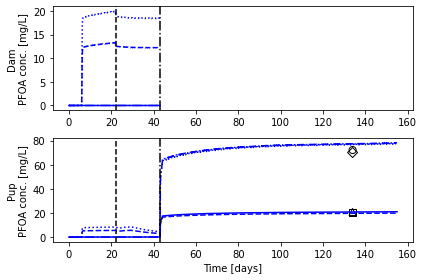

In [23]:
# Dictionary for dosing-specific parameters
t_gest = 22 # 22 days of gestation
t_lact = 21

dev_metrics = [
    'Cmax_dam', 'Cavg_dam', 'AUCavg_dam_gest', 'AUCavg_dam_lact', 'AUCavg_dam_gest_lact',
    'Cavg_pup_gest', 'Cmax_pup_gest', 'Cavg_pup_lact', 'Cmax_pup_lact', 'Cavg_pup_gest_lact', 
              'AUCavg_pup_gest', 'AUCavg_pup_lact', 'AUCavg_pup_gest_lact',
'Cmax_pup_wean', 'Css_pup_wean', 'AUCavg_pup_diet', 'AUCavg_pup_total'

]

t_f = 7*19+t_gest # PNW19
#t_f = 2*365 # 2 years
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Female_0-300')
final_metrics = []
dosing_dict = {
    'growth_data': pup_growth, # Reported pup weights from NTP study
    
    'chem': 'PFOA',
    'ts': 0,         # Start simulation at conception
    'tf': t_f,     # PNW19
    't_dose': 0.999,     # Dose in feed, assume mg/kg/day applied over entire day
    't_dose_i': 0.999,   # Dose in feed for pup
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Female',         # Pups are Female
    
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,  
    
    'dose': 0,          # 0 ppm --> mg/kg dose to dam
    't_m_start':6,         # Start maternal dosing on GD6
    't_m_end': t_gest+t_lact,      # End maternal dosing on 21 days post-partum
    'M_m_1': 0.27,         # Initial Dam weight
    'M_m_2': 0.281,         # Final Dam weight (post-partum)

    'dose_i': 21.8,       # 300 ppm --> mg/kg dose to pup
    't_i_start': t_gest+t_lact,
    't_i_end': t_f,
    
    # Female infant weights during lactation (Table )
    'M_i_1': 0.00687,     # Infant mass 1 (kg).
    'M_i_2': 0.00956,      # Infant mass 2 (kg).
    'M_i_3': 0.01466,      # Infant mass 3 (kg).
    'M_i_4': 0.04868,       # Infant mass 4 (kg).
    
    't_i_1': 1,          # Time (d) since birth for infant mass 1.
    't_i_2': 4,         # Time (d) since birth for infant mass 2.
    't_i_3': 7,         # Time (d) since birth for infant mass 3.
    't_i_4': 21,         # Time (d) since birth for infant mass 4.
    
    'route': 'oral',       # Oral route of exposure
    
    'tm_daily_dose': [0],  # Once daily dosing
    'ti_daily_dose': [0],  # Once daily dosing
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
}

# 0/300
test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='blue')
test_PFOA.plot_data([16*7+t_gest], [20.42], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='s')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam not dosed', 'sex': 'Female', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 20.42, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)

#0/1000
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Female_0-1000')
test_PFOA.update_p(dose=0, dose_i=104.4, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-.', color='blue')
test_PFOA.plot_data([16*7+t_gest], [72.25], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='o')
NTP_compare = NTP_compare.append({'source': 'NTP 2020',  'dam': 'dam not dosed', 'sex': 'Female', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 72.25, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)

# #150/300
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Female_150-300')
test_PFOA.update_p(dose=10.9, dose_i=20.42, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='--', color='blue')
test_PFOA.plot_data([16*7+t_gest], [20.8], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='^')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam dosed', 'sex': 'Female', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 20.8, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)

# #300/1000
pup_growth = pd.read_excel('../data_files/NTP_growth.xlsx', sheet_name='Female_300-1000')
test_PFOA.update_p(dose=18.4, dose_i=104.4, growth_data=pup_growth)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle=':', color='blue')
test_PFOA.plot_data([16*7+t_gest], [70.16], lifestage='pup', s=50, facecolors='none', edgecolors='black', marker='D')
NTP_compare = NTP_compare.append({'source': 'NTP 2020', 'dam': 'dam dosed', 'sex': 'Female', 'species': 'rat', 'lifestage': 'post-weaning', 'conc_mean': 70.16, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'] == 16*7+t_gest, 'C_i'].item()}, ignore_index=True)
# test_PFOA.add_features(disp_birth=True, disp_lact=True)

test_PFOA.add_features(disp_birth=True, disp_lact=True)

test_PFOA.ax[1].get_legend().remove()

## Hinderliter, 2005: Rat

Running developmental model
current adult dose 30
current infant dose 0


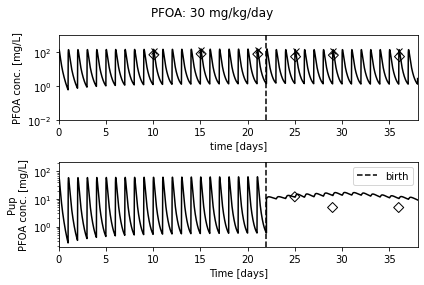

In [24]:
# Dictionary for simulation-specific parameters
simulation_dict = {
    'chem': 'PFOA',
    'ts': -2,                  # Start simulation at conception
    'tf': 22+22,               # 22 days of gestation plus  21 days post-partum
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Male',
    'strain': 'rat',            # Rat simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,               # Developmental simulation
}

# Dictionary for dosing-specific parameters
dosing_dict = {
    't_m_start':0,         # Start maternal dosing at conception
    't_m_end': 22+22,      # End maternal dosing at 22 days gestation plus 21 days post-partum
    't_step':0.001,
    'route': 'oral',       # Oral route of exposure
    'dose': 30,             # 30 mg/kg dose
    'tm_daily_dose': [0],  # Once daily dosing
    't_dose': 0.003,
    'n_f': 7,
}

# Dictionary for user-defined pharmacokinetic parameters
pk_dict = {
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.
    #'r_f_m': 0.42,     # Ratio of fetal and maternal concentrations
    #'P_milk': 0.11,    # Maternal serum : Milk partitioning
    #'half_life': 5.11,  # Half-life (days) in the pup
    #'Vcc_i': .11       # Pup central compartment volume, i.e. Volume of distribution
    
}

dosing_dict.update(simulation_dict)
dosing_dict.update(pk_dict)

test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='black')

maternal_time = np.append(np.array([10, 15, 21])+(2/24.), np.array([3, 7, 14, 21])+test_PFOA.t_gest+(2/24.))
maternal_conc = np.array([70.5, 79.6, 76.4, 54.4, 66.9, 54.7, 64.1])
#maternal_conc = np.array([22.5, 25.74324324, 23.85135135, 28.71621622])
pup_time = np.array([3, 7, 14, 21])+test_PFOA.t_gest
#pup_conc = np.array([5.940397832, 2.763535228, 2.195732582, 3.214734318])
pup_conc = np.array([12, 4.92, 4.91, 7.36])
test_PFOA.plot_data(maternal_time, maternal_conc, lifestage='adult', s=50, edgecolors='black', marker='D', facecolors='none')
test_PFOA.plot_data(pup_time, pup_conc, lifestage='infant', s=50, edgecolors='black', marker='D',facecolors='none')

NTP_compare = pd.concat([NTP_compare, pd.DataFrame({'source': ['Hinderliter 2005']*len(pup_time), 'dam': ['dam dosed']*len(pup_time), 'sex': ['Male/Female']*len(pup_time), 'species': ['rat']*len(pup_time), 'lifestage': ['lactation']*len(pup_time), 
                                  'conc_mean': pup_conc, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'].isin(pup_time), 'C_i'].values})])



find_time = np.round(maternal_time, 2)
sim_conc = []
for time in find_time:
    result_index = test_PFOA.output['time'].sub(time).abs().idxmin()
    sim_conc.append(test_PFOA.output.loc[result_index, 'C_m'])
test_PFOA.ax[0].plot(maternal_time, sim_conc, 'kx', markeredgewidth=1)

# Experiment #2
#test_PFOA.update_p(dose=10)
#test_PFOA.run_model()
#test_PFOA.plot_time_course(linestyle='--', color='red')

test_PFOA.ax[0].set_yscale('log')
test_PFOA.ax[0].set_ylim(1e-2, 1e3)
test_PFOA.ax[1].set_yscale('log')
test_PFOA.ax[0].set_xlim(0, 38)
test_PFOA.ax[1].set_xlim(0, 38)
test_PFOA.ax[0].set_xlabel('time [days]')
test_PFOA.ax[0].set_ylabel('PFOA conc. [mg/L]')
test_PFOA.fig.suptitle('PFOA: 30 mg/kg/day')
test_PFOA.add_features(disp_birth=True)
test_PFOA.fig.tight_layout()

## White, 2009: Mouse

Running developmental model
current adult dose 5
current infant dose 0
Running developmental model
current adult dose 5
current infant dose 0


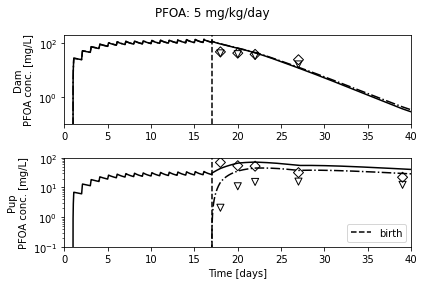

In [25]:
# Dictionary for simulation-specific parameters
# Mouse specific parameters
t_gest = 17        # Duration (d) of pregnancy/gestation.
t_lact = 21        # Duration (d) of lactation/nursing.

M_m_1 = 0.0255       # Maternal mass 1 (kg).
M_m_2 = 0.0318      # Maternal mass 2 (kg).
t_m_1 = 1          # Time (d) since conception for maternal mass 1.
t_m_1 = 25          # Time (d) since conception for maternal mass 1.

n_f = 8           # Effective number of fetuses.
n_i = 8           # Number of infants.

# Lau et al., 2003 (Table 3)
M_i_1 = 0.0014,     # Infant mass 1 (kg).
M_i_2 = 0.00608      # Infant mass 2 (kg).
M_i_3 = 0.00885      # Infant mass 3 (kg).
M_i_4 = 0.03      # Infant mass 4 (kg).
t_i_1 = 1,          # Time (d) since birth for infant mass 1.
t_i_2 = 10          # Time (d) since birth for infant mass 2.
t_i_3 = 18         # Time (d) since birth for infant mass 3.
t_i_4 = 45         # Time (d) since birth for infant mass 4.

r_milk_0 = 0.0001   # Rate (kg/d) of milk ingestion at birth.
r_milk_1 = 0.0003   # Rate (kg/d) of milk ingestion during week 1.
r_milk_2 = 0.00054  # Rate (kg/d) of milk ingestion during week 2.
r_milk_3 = 0.00059  # Rate (kg/d) of milk ingestion during week 3.
simulation_dict = {
    'chem': 'PFOA',
    'ts': 0,                  # Start simulation at conception
    'tf': 22+22,               # 22 days of gestation plus  42 days post-partum
    't_dose': 0.1,
    't_step':0.001,
    'sex': 'Female',           # Dams are Female
    'sex_i': 'Female',       # Offspring are Female
    'strain': 'CD1',            # CD1 mouse simulation
    'sample_posterior': False, # Don't sample posterior distributions
    'param_path': param_path,
    'model_path': model_path,
    'dev': True,               # Developmental simulation
    't_gest': t_gest,  # 17 day gestation
    't_lact': 30
}

# Dictionary for dosing-specific parameters
dosing_dict = {
    't_m_start':1,         # Start maternal dosing at conception
    't_m_end': 17,      # End maternal dosing at PND17
    'route': 'oral',       # Oral route of exposure
    'dose': 5,             # 1.6 mg/kg dose
    'tm_daily_dose': [0],  # Once daily dosing
}

# Dictionary for user-defined pharmacokinetic parameters
pk_dict = {
    'Qcc': 8.68,      # Qcc for rats from Wambaugh et al.
    #'r_f_m': 1.5,     # Ratio of fetal and maternal concentrations
    #'P_milk': 0.13,    # Maternal serum : Milk partitioning
    #'half_life': 40,  # Half-life (days) in the pup
    #'Vcc_i': .28,       # Pup central compartment volume, i.e. Volume of distribution
    
    # Use the repored weights for Treated Dam/Treated Pup
    'M_m_1': 0.02,
    'M_m_2': 0.037,
    
    'M_i_1': 0.0016,     # Infant mass 1 (kg).
    'M_i_2': 0.00185,      # Infant mass 2 (kg).
    'M_i_3': 0.00243,      # Infant mass 3 (kg).
    'M_i_4': 0.00434,       # Infant mass 4 (kg).
    
    't_i_1': 1,          # Time (d) since birth for infant mass 1.
    't_i_2': 3,         # Time (d) since birth for infant mass 2.
    't_i_3': 5,         # Time (d) since birth for infant mass 3.
    't_i_4': 10,         # Time (d) since birth for infant mass 4.
    
    'r_milk_0': r_milk_0,
    'r_milk_1': r_milk_1,
    'r_milk_2': r_milk_2,
    'r_milk_3': r_milk_3,
    
    
}

dosing_dict.update(simulation_dict)
dosing_dict.update(pk_dict)

test_PFOA = PFAS_DR(**dosing_dict)
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-', color='black')

# Treated Dam/Treated Pup
maternal_time =  np.array([1, 3, 5, 10])+test_PFOA.t_gest
maternal_conc = np.array([47994.51129, 43048.28845, 38769.00793, 24356.42218])/1000.
pup_time = np.array([1, 3, 5, 10, 22])+test_PFOA.t_gest
pup_conc = np.array([70071.59189, 54325.53777, 52312.91762, 31767.01556, 22154.4165])/1000.
test_PFOA.plot_data(maternal_time, maternal_conc, lifestage='adult', s=50, edgecolors='black', marker='D', facecolor='none')
test_PFOA.plot_data(pup_time, pup_conc, lifestage='infant', s=50, edgecolors='black', marker='D', facecolor='none')

NTP_compare = pd.concat([NTP_compare, pd.DataFrame({'source': ['White 2009']*len(pup_time), 'dam': ['dam dosed']*len(pup_time), 'sex': ['Male/Female']*len(pup_time), 'species': ['mouse']*len(pup_time), 'lifestage': ['lactation']*len(pup_time), 
                                  'conc_mean': pup_conc, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'].isin(pup_time), 'C_i'].values})])


# Treated Dam/Control Pup
test_PFOA.update_p(r_f_m=0, dose=5,
                  M_m_2=0.0382,
                   
                  M_i_1 = 0.0016,     
                  M_i_2 = 0.00225,      
                  M_i_3 = 0.00303,     
                  M_i_4 = 0.00564,
                  )
test_PFOA.run_model()
test_PFOA.plot_time_course(linestyle='-.', color='black')
maternal_time =  np.array([1, 3, 5, 10])+test_PFOA.t_gest
maternal_conc = np.array([42129.1096, 39316.35292, 33704.02025, 16224.36011])/1000.
pup_time = np.array([1, 3, 5, 10, 22])+test_PFOA.t_gest
pup_conc = np.array([2073.306768, 10993.57338, 15380.93547, 15768.16991, 12289.02591])/1000.
test_PFOA.plot_data(maternal_time, maternal_conc, lifestage='adult', s=50, edgecolors='black', marker='v', facecolor='none')
test_PFOA.plot_data(pup_time, pup_conc, lifestage='infant', s=50, edgecolors='black', marker='v', facecolor='none')

NTP_compare = pd.concat([NTP_compare, pd.DataFrame({'source': ['White 2009']*len(pup_time), 'dam': ['dam not dosed']*len(pup_time), 'sex': ['Male/Female']*len(pup_time), 'species': ['mouse']*len(pup_time), 'lifestage': ['lactation']*len(pup_time), 
                                  'conc_mean': pup_conc, 'conc_pred': test_PFOA.output.loc[test_PFOA.output['time'].isin(pup_time), 'C_i'].values})])



# Add vertical birth lines
#test_PFOA.ax[0].vlines(test_PFOA.t_gest, *test_PFOA.ax[0].get_ylim())

test_PFOA.ax[0].set_yscale('log')
test_PFOA.ax[1].set_yscale('log')
test_PFOA.ax[0].set_xlim(0, 40)
test_PFOA.ax[1].set_xlim(0, 40)
test_PFOA.ax[1].set_ylim(1e-1, 1e2)
test_PFOA.fig.suptitle('PFOA: 5 mg/kg/day')
test_PFOA.add_features(disp_birth=True)
test_PFOA.fig.tight_layout()

Text(0.5, 0, 'Literature reported concentration (mg/L)')

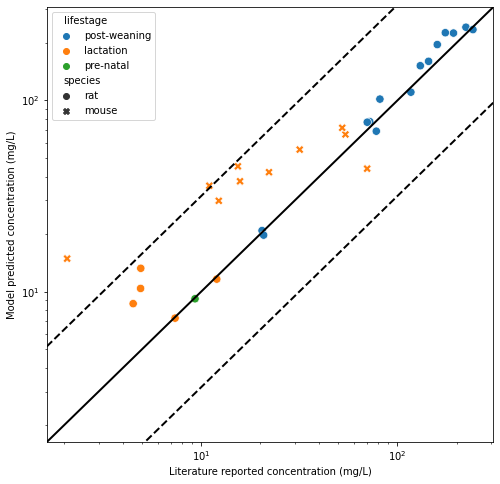

In [26]:
# UPDATED PARAMS (Adult Vd)
fig, ax = plt.subplots(1,1, figsize=(8,8))
NTP_compare['study design'] = NTP_compare['source'] + ' (' + NTP_compare['lifestage'] + ')' + ': ' + NTP_compare['dam']
sns.scatterplot(x='conc_mean', y='conc_pred', data=NTP_compare, hue='lifestage', ax=ax, style='species', s=70)
ax.set_xscale('log')
ax.set_yscale('log')
ylim = ax.get_ylim()
xlim = ax.get_xlim()
axis_max = max(xlim[1], ylim[1])
axis_min = min(xlim[0], ylim[0])
ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k-', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**0.5), axis_max*(10**0.5)], 'k--', linewidth=2)
ax.plot([axis_min, axis_max], [axis_min*(10**-0.5), axis_max*(10**-0.5)], 'k--', linewidth=2)
ax.set_ylim([axis_min, axis_max])
ax.set_xlim([axis_min, axis_max])
ax.set_ylabel('Model predicted concentration (mg/L)')
ax.set_xlabel('Literature reported concentration (mg/L)')

In [27]:
print('MSLE: ', np.round(skm.mean_squared_log_error(NTP_compare['conc_mean'], NTP_compare['conc_pred']), 3))

MSLE:  0.308
